# <center> IMDB sentiment analysis of reviews using an LSTM  </center> <br>

### This Dataset contains highly polar IMDB movie reviews that canbe used for binary sentiment classification (predict if review is positive or negative). 

<br>

Dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords 
from string import punctuation
from sklearn.model_selection import train_test_split
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("IMDB Dataset.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


<Axes: xlabel='sentiment', ylabel='count'>

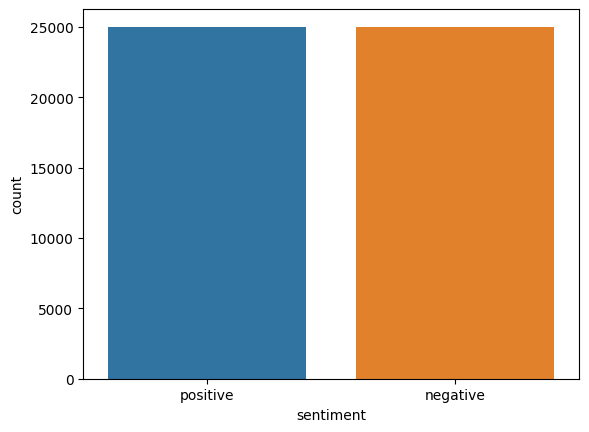

In [4]:
sns.countplot(x ='sentiment', data = df, hue='sentiment')

# Transform each entry to a list of words
- Removea all occurrences of "\<br /\>"
- Remove all punctuation including tabs and newlines.
- Convert all words to lower case.
- Split the input string into words using space as the separator.

In [5]:
print(df['review'][0])

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fac

# Extract adjectives from reviews

In [6]:
stop_words = stopwords.words('english')

def filter_txt(txt_str):
    
    filtered_sentence = txt_str.replace("<br />","")
    filtered_sentence = txt_str.replace("'ll","")
    filtered_sentence = txt_str.replace("'","")

    # Keep only adjectives
    word_tokens = text_to_word_sequence(filtered_sentence)
    filtered_sentence = [w for w,tag in nltk.pos_tag(word_tokens) if (tag[0] in "JJ") and (len(w)>3) and (w not in stop_words)]
    filtered_sentence = ''.join(str(x)+' ' for x in filtered_sentence)
    #print(filtered_sentence)
    #print("\n")
    
    return filtered_sentence

In [7]:
df['review'] = df['review'].apply(filter_txt)

In [8]:
print(df['review'][3])

little slower rambo first watchable real boogeyman similar thriller descent 


# Join all Reviews in order to generate a vocabulary

In [9]:
reviews = df[['review']].to_string(header=False,
                  index=False,
                  index_names=False).split('\n')
reviews_words = [w.split() for w in reviews]

In [10]:
def flatten_comprehension(reviews_words):
    return [w for words in reviews_words for w in words]
flattened_reviews_words = flatten_comprehension(reviews_words)

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(flattened_reviews_words)
tokens = tokenizer.word_index

In [12]:
print(len(np.unique(flattened_reviews_words)))
print(len(tokenizer.word_index))

34012
34012


# Get the Vocabulary Size

In [13]:
vocabulary_size = len(tokenizer.word_index) + 1
print(vocabulary_size)

34013


# Build sequences of tokens

In [14]:
# Get max reviw length
max_review_length = max([len(review) for review in reviews])

In [15]:
# build subsequences of different sizes, starting from 1 to the size of the sequence. 
sequences = tokenizer.texts_to_sequences(reviews)
sequences = pad_sequences(sequences, maxlen=max_review_length, padding='pre')

In [16]:
print(sequences.shape)
print(sequences[0])

(50000, 1483)
[   0    0    0 ...  630  539 1049]


# Build Input and Output
#### The input to the network is all the words of the sequence except the last one, and the output is the last word of the sequence.
#### Then, convert output into categorical data using the to_categorical() method from the keras.utils module.

In [17]:
X = sequences
y = to_categorical(df[['sentiment']].to_numpy()=="positive", num_classes=2)
y = np.round(df[['sentiment']].to_numpy()=="positive")

In [18]:
print(X.shape)
print(y.shape)

(50000, 1483)
(50000, 1)


In [19]:
X[0]

array([   0,    0,    0, ...,  630,  539, 1049])

# Build training, validationand test sets

In [20]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.2, random_state=0)

In [21]:
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)

print(X_test.shape)
print(y_test.shape)

(32000, 1483)
(32000, 1)
(8000, 1483)
(8000, 1)
(10000, 1483)
(10000, 1)


# Train an ANN to perform NLP

In [22]:
model=Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=max_review_length,input_length=max_review_length))
model.add(LSTM(10, kernel_regularizer=regularizers.L2(1e-2),recurrent_regularizer=regularizers.L2(1e-2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='sigmoid'))

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1483, 1483)        50441279  
                                                                 
 lstm (LSTM)                 (None, 10)                59760     
                                                                 
 batch_normalization (Batch  (None, 10)                40        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 50501090 (192.65 MB)
Trainable params: 50501070 (192.65 MB)
Non-trainable params: 20 (80.00 Byte)
__________

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size=32, 
                    epochs=10, 
                    validation_data=(X_valid, y_valid), 
                    callbacks=[PlotLossesKeras()],
                    verbose=1)

Epoch 1/10


 329/1000 [========>.....................] - ETA: 8:09 - loss: 0.6913 - accuracy: 0.7482

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate model

In [ ]:
model.evaluate(x, y)